In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, GRU
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential

%matplotlib inline

In [29]:
MODEL_SAVE_PATH = './model_weights/'
RANDOM_SEED = 15

# Importing Data

In [3]:
reliance = pd.read_csv('H:\Excelr\Project\Stock_Prediction\Program\Reliance_5_years.csv')

In [4]:
reliance.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2017-01-02,RELIANCE,EQ,1082.40,1084.00,1090.0,1072.35,1086.70,1085.10,1086.63,1622458,1.763016e+14,38903,881915,0.5436
1,2017-01-03,RELIANCE,EQ,1085.10,1089.85,1097.0,1081.10,1089.00,1089.40,1091.74,1470751,1.605682e+14,31291,776985,0.5283
2,2017-01-04,RELIANCE,EQ,1089.40,1092.90,1093.0,1064.30,1067.15,1067.15,1072.39,2375547,2.547514e+14,70540,1516724,0.6385
3,2017-01-05,RELIANCE,EQ,1067.15,1071.00,1079.9,1068.75,1077.00,1077.40,1077.12,1996483,2.150452e+14,84058,1272212,0.6372
4,2017-01-06,RELIANCE,EQ,1077.40,1074.20,1085.0,1073.10,1073.95,1074.95,1078.77,1793427,1.934704e+14,66643,1121595,0.6254


# Dataset creation

In [5]:
def Time_series_dataset(data, time_step, columns, target_colm, values_in_target = 1, dataframe = False):
    '''
    This function returns two arrays one dataset and other target dataset.
    target dataset can be singular or multiples 
    - data : dataframe object consists of feature and target_colm
    - time_step : window size for building dataset
    - columns : list of columns that will be used as features
    - target_colm : list of target_colm 
    - values_in_target : It is the no of values should be in target columns of dataset
    '''
    n = len(columns)
    for i in range(data.shape[0]-time_step-values_in_target):
        values = data[columns][i:time_step+i].to_numpy().reshape(-1,time_step,n)

        target_value = data[target_colm].iloc[time_step+i:time_step+i+values_in_target,:].to_numpy()
        target_value = target_value.reshape(-1, target_value.shape[0], target_value.shape[1])
        if i == 0:
            dataset = values
            target_values = target_value
        else:
            dataset = np.concatenate((dataset, values))
            target_values = np.concatenate((target_values, target_value))
    if columns == target_colm and len(columns) == 1 and dataframe is True:
        dataset = dataset.reshape(dataset.shape[0], -1)
        target_values = target_values.reshape(dataset.shape[0], -1)
        data = pd.DataFrame(dataset)
        data['target'] = target_values
        return data
    else:
        if len(target_colm)==1:
            target_values = target_values.reshape(target_values.shape[0], -1)
        return dataset, target_values

In [6]:
open_dataset_multi_target, target_multi_target = Time_series_dataset(reliance, 50, ['Open']
        , ['Open'])

In [7]:
open_dataset_multi_target.shape, target_multi_target.shape

((1233, 50, 1), (1233, 1))

In [8]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

def Splitting_dataset(data, train_ratio = train_ratio, valid_ratio = None, target_variable = None):
    '''
    This Function Splits time series data into train, test and validation data with given percentages
    
    - train_ratio : percentage of data contained in training set
    - valid_ratio : percentage of data contained in validation set
    - target_variable : If given data does not contain final column as target column then provide target array

    Return:
    - If valid_ratio is provided the dataset will be split into 3 set with order as:
    x_train, x_val, x_test, y_train, y_val, y_test

    - If only train_ratio is provided the dataset will be divided into 2 sets as:
    x_train, x_test, y_train, y_test
    '''
    if target_variable is None:
        obs = data.shape[0]
        training_rows = int(obs*train_ratio)
        if valid_ratio:
            valid_rows = int(obs*valid_ratio)
            A = training_rows+valid_rows
            x_train, y_train = data.iloc[:training_rows,:-1].to_numpy(), data.iloc[:training_rows,-1].to_numpy()
            x_val, y_val = data.iloc[training_rows:A, :-1].to_numpy(), data.iloc[training_rows:A, -1].to_numpy()
            x_test, y_test = data.iloc[A:,:-1].to_numpy(), data.iloc[A:,-1].to_numpy()
            return x_train, x_val, x_test, y_train, y_val, y_test
        else:
            x_train, y_train = data.iloc[:training_rows,:-1].to_numpy(), data.iloc[:training_rows,-1].to_numpy()
            x_test, y_test = data.iloc[training_rows:, :-1].to_numpy(), data.iloc[training_rows:,-1].to_numpy()
            return x_train, x_test, y_train, y_test

    else:
        obs = data.shape[0]
        training_rows = int(obs*train_ratio)
        if valid_ratio:
            valid_rows = int(obs*valid_ratio)
            A = training_rows+valid_rows
            x_train, y_train = data[:training_rows], target_variable[:training_rows]
            x_val, y_val = data[training_rows:A], target_variable[training_rows:A]
            x_test, y_test = data[A:], target_variable[A:]
            return x_train, x_val, x_test, y_train, y_val, y_test
        else:
            x_train, y_train = data[:training_rows], target_variable[:training_rows]
            x_test, y_test = data[training_rows:], target_variable[training_rows:]
            return x_train, x_test, y_train, y_test




def transformation_min_max(data, min, max):
    data = (data - min)/(max- min)
    return data

In [9]:
x_train_multi_target, x_test_multi_target, y_train_multi_target, y_test_multi_target=Splitting_dataset(
        open_dataset_multi_target, target_variable= target_multi_target)

In [10]:
x_train_multi_target.shape, y_train_multi_target.shape, x_test_multi_target.shape

((863, 50, 1), (863, 1), (370, 50, 1))

In [11]:
x_train_multi_target.max()

2178.8

In [12]:
train_min_multi_target = x_train_multi_target.min()
train_max_multi_target = x_train_multi_target.max()

In [13]:
train_min_multi_target, train_max_multi_target

(791.75, 2178.8)

In [14]:
scaled_data = transformation_min_max(open_dataset_multi_target, train_min_multi_target, train_max_multi_target)

In [15]:
scaled_data_target = transformation_min_max(target_multi_target, train_min_multi_target, train_max_multi_target)

In [16]:
scaled_data[-1].shape, scaled_data_target[-1].shape

((50, 1), (1,))

In [44]:
forecasting_data = scaled_data_target[-50:]

In [46]:
forecasting_data.shape

(50, 1)

In [18]:
x_train_multi_target = transformation_min_max(x_train_multi_target, train_min_multi_target, train_max_multi_target)
x_test_multi_target = transformation_min_max(x_test_multi_target, train_min_multi_target, train_max_multi_target)
# x_val_multi_target = transformation_min_max(x_val_multi_target, train_min_multi_target, train_max_multi_target)

y_train_multi_target = transformation_min_max(y_train_multi_target, train_min_multi_target, train_max_multi_target)
y_test_multi_target = transformation_min_max(y_test_multi_target, train_min_multi_target, train_max_multi_target)
# y_val_multi_target = transformation_min_max(y_val_multi_target, train_min_multi_target, train_max_multi_target)

In [19]:
x_train_multi_target.shape, y_train_multi_target.shape, x_test_multi_target.shape

((863, 50, 1), (863, 1), (370, 50, 1))

In [20]:
(x_train_multi_target.max(axis = (0,1)), 
x_test_multi_target.max(axis = (0,1)), y_train_multi_target.max())

(array([1.]), array([1.40658231]), 1.0)

# Model finetunning

## Complex model

In [35]:
model_3 = Sequential([
    layers.Bidirectional(LSTM(50, recurrent_regularizer= tf.keras.regularizers.L2(0.1), 
                input_shape = (50,1), return_sequences= True), input_shape = (50,1)),
    layers.Bidirectional(LSTM(50, recurrent_regularizer= tf.keras.regularizers.L2(0.1),
                return_sequences= True)),
    GRU(50),
    Dense(25, activation = 'relu'),
    Dense(1)
])

model_3.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mae']
)

In [27]:
model_3.build(input_shape = (50,1))

In [36]:
model_3.load_weights(MODEL_SAVE_PATH + 'for_deployment.h5')

In [37]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 50, 100)          20800     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 50, 100)          60400     
 nal)                                                            
                                                                 
 gru_2 (GRU)                 (None, 50)                22800     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 105,301
Trainable params: 105,301
Non-tr

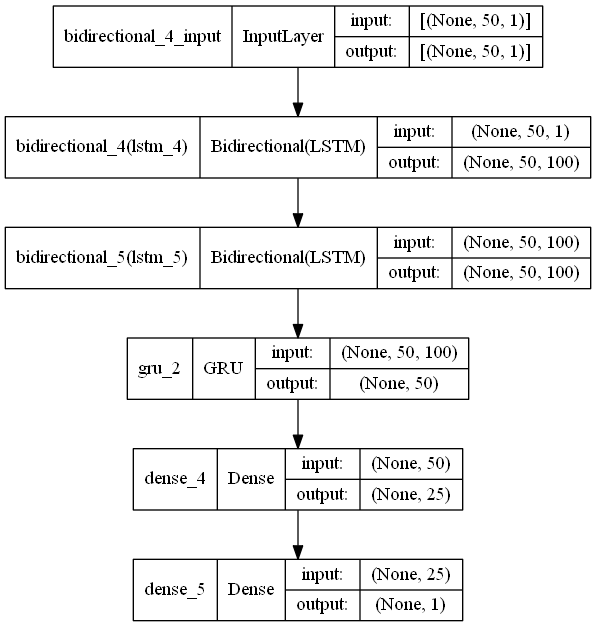

In [38]:
plot_model(model_3, show_layer_names= True, show_shapes=True)

In [39]:
model_3.evaluate(x_test_multi_target, y_test_multi_target)

12/12 [==============================] - 23s 45ms/step - loss: 8.2816e-04 - mae: 0.0216 0s - loss: 8.0880e-04 - mae: 0.02


[0.0008281635236926377, 0.021561821922659874]

In [40]:
model_3.fit(scaled_data, scaled_data_target,
     epochs=10) 

Epoch 1/10
39/39 [==============================] - 14s 55ms/step - loss: 0.0017 - mae: 0.0246
Epoch 2/10
39/39 [==============================] - 2s 52ms/step - loss: 8.6960e-04 - mae: 0.0176
Epoch 3/10
39/39 [==============================] - 2s 51ms/step - loss: 9.4653e-04 - mae: 0.0185
Epoch 4/10
39/39 [==============================] - 2s 51ms/step - loss: 9.9796e-04 - mae: 0.0194
Epoch 5/10
39/39 [==============================] - 2s 53ms/step - loss: 9.6640e-04 - mae: 0.0194 - loss: 0.
Epoch 6/10
39/39 [==============================] - 2s 52ms/step - loss: 9.0054e-04 - mae: 0.0183
Epoch 7/10
39/39 [==============================] - 2s 55ms/step - loss: 8.9365e-04 - mae: 0.0180
Epoch 8/10
39/39 [==============================] - 2s 53ms/step - loss: 8.8675e-04 - mae: 0.0179
Epoch 9/10
39/39 [==============================] - 2s 55ms/step - loss: 9.5854e-04 - mae: 0.0193
Epoch 10/10
39/39 [==============================] - 2s 57ms/step - loss: 9.1252e-04 - mae: 0.0184 - loss: 0.0

In [43]:
forecasting_data.shape

(1233, 1)

In [56]:
ROWS = for_forecasting_10day.shape[0]
COLS = for_forecasting_10day.shape[1]
forecasting = model_reweight.predict(for_forecasting_10day.reshape((-1,ROWS,COLS)))

In [71]:
x_test_multi_target.shape, y_test_multi_target.shape

((359, 80, 2), (359, 10, 2))

In [74]:
y_test_pred = model_reweight.predict(x_test_multi_target)

In [65]:
for_forecasting_10day[:,0]

array([1.25654939, 1.27297229, 1.29963704, 1.27954864, 1.22700974,
       1.19901534, 1.18183778, 1.10777303, 1.14151723, 1.13648615,
       1.20462141, 1.18399396, 1.20476516, 1.17960973, 1.20598699,
       1.22661444, 1.16739138, 1.13875013, 1.17321307, 1.18104718,
       1.1848205 , 1.20871815, 1.14151723, 1.14439214, 1.1599885 ,
       1.15449024, 1.09684838, 1.09217666, 1.10191541, 1.13720487,
       1.13432997, 1.12825673, 1.13835484, 1.14942322, 1.15589176,
       1.13648615, 1.13073634, 1.16731951, 1.2004528 , 1.19269055,
       1.17813634, 1.19326553, 1.18176591, 1.20713695, 1.24303734,
       1.25291983, 1.25507601, 1.26711467, 1.24932619, 1.22780034,
       1.19326553, 1.20979624, 1.11963201, 1.10989327, 1.13073634,
       1.12728645, 1.16164157, 1.16092284, 1.15014195, 1.1134869 ,
       1.11420563, 1.10604808, 1.1351565 , 1.15280124, 1.13666583,
       1.11294786, 1.12081791, 1.17745355, 1.17033816, 1.18780321,
       1.16451648, 1.12203975, 1.15668236, 1.08761275, 1.06971

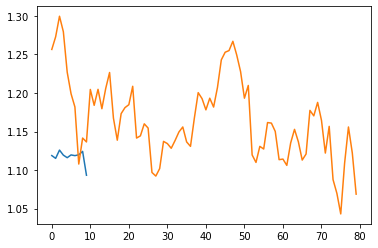

In [66]:
plt.plot(forecasting[0].ravel())
plt.plot(for_forecasting_10day[:,0])

In [79]:
y_test_pred[0][0].shape

(10,)

In [88]:
y_test_multi_target[0][:,0]

array([1.10198728, 1.0926079 , 1.09839365, 1.09839365, 1.09426097,
       1.08401912, 1.06748841, 1.05527006, 1.01782442, 1.00424049])

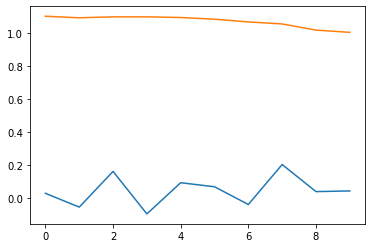

In [89]:
plt.plot(y_test_pred[0][0].ravel())
plt.plot(y_test_multi_target[0][:,0] )

## Bidirectional model

TypeError: __init__() got an unexpected keyword argument 'reduction'